In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Clustering

### 1.1. Data preprocessing

In [3]:
df = pd.read_excel("data/model_df.xlsx")
df.columns

Index(['Unnamed: 0', 'id', 'plec', 'wiek', 'wyksztalcenie', 'branza',
       'stanowisko', 'miejsce_zamieszkania', 'polska_zagranica', 'korzystanie',
       'prenumerata', 'prenumerata_zachety', 'prenumerata_zachety_cat',
       'prenumerata_rodzaj', 'prenumerata_motywy', 'prenumerata_motywy_cat',
       'jak_dawno', 'jak_czesto', 'wspiera', 'dlaczego_wspiera',
       'zrodlo_informacji', 'czytanie_motywy', 'najchetniej_czytane',
       'nieczytane', 'tylko_wiez_pl', 'dlaczego_wiez_pl',
       'kategorie_najchetniej', 'najwazniejsze_tematy', 'wiecej_gatunki',
       'tematy_za_malo', 'tresci_za_malo', 'tresci_za_malo_cat', 'sociale',
       'zamalo_sociale', 'zamalo_sociale_cat', 'polecenie', 'podcasty',
       'podcasty_jakie', 'podcasty_jakie_cat', 'youtube', 'youtube_jakie',
       'youtube_jakie_cat', 'fb_jakie', 'sugestie'],
      dtype='object')

In [4]:
model_df = pd.DataFrame()


In [5]:
dummies_no_sep = ["plec", "wiek", "wyksztalcenie", "branza", "stanowisko", "miejsce_zamieszkania", "polska_zagranica", "jak_dawno", "jak_czesto", "kategorie_najchetniej", "podcasty", "youtube"]

In [6]:
for variable in dummies_no_sep:
    dummies = pd.get_dummies(df[variable], prefix=variable)
    model_df = pd.concat([model_df, dummies], axis=1)

In [7]:
dummies_sep = ["korzystanie", "zrodlo_informacji", "czytanie_motywy", "najchetniej_czytane", "nieczytane", "najwazniejsze_tematy", "tematy_za_malo"]

In [8]:
prefix_list = []
for variable in dummies_sep:
    dummies = df[variable].str.get_dummies(sep=";")
    prefix = f"{variable}_"
    prefix_list.append(prefix)
    for column_index in range(len(dummies.columns)):
        dummies.rename(columns={dummies.columns[column_index]: f"{prefix}{dummies.columns[column_index]}"}, inplace=True)
    model_df = pd.concat([model_df, dummies], axis=1)

In [9]:
for column in model_df.columns:
    if np.sum(model_df[column])<50:
        model_df = model_df.drop(column, axis=1)

In [10]:
model_df.head()

,plec_Kobieta,plec_Mężczyzna,wiek_26-35,wiek_36-50,wiek_51-65,wyksztalcenie_Wyższe,branza_Edukacja,branza_Inne,stanowisko_Menadżer/ka/kierownik/czka,stanowisko_Specjalista/ka,...,najwazniejsze_tematy_Wiara,najwazniejsze_tematy_Żydzi,tematy_za_malo_Duchowość,tematy_za_malo_Edukacja,tematy_za_malo_Etyka,tematy_za_malo_Filozofia,tematy_za_malo_Gospodarka,tematy_za_malo_Inne religie,tematy_za_malo_Teologia,tematy_za_malo_Wiara
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0,1,1,0,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,1,0,0,1,1,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca_wiez = pca.fit(model_df.drop("prenumerata", axis=1))

In [ ]:
pca_df = pd.DataFrame(pca_wiez.components_, columns = list(model_df.drop("prenumerata", axis=1).columns))

In [95]:
pca_df.T.to_excel("principal_components.xlsx")

## 2. Prenumerata

In [12]:
prenumerata_tak_nie = []
for row in df["prenumerata"]:
    if "Tak" in row:
        prenumerata_tak_nie.append(1)
    else:
        prenumerata_tak_nie.append(0)

model_df["prenumerata_tak_nie"] = prenumerata_tak_nie

In [13]:
model_df[["plec_Kobieta", "plec_Mężczyzna", "prenumerata_tak_nie"]].head(10)

,plec_Kobieta,plec_Mężczyzna,prenumerata_tak_nie
0,1,0,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0
5,0,1,1
6,1,0,0
7,0,1,0
8,0,1,0
9,0,1,1


In [14]:
model_df[model_df["prenumerata_tak_nie"] == 1].mean().to_excel("prenumerata_means.xlsx")


## 2. Regression

In [15]:
model_df["polecenie"] = df["polecenie"]
model_full = model_df.dropna()
columns_to_drop = ['plec_Mężczyzna', 'miejsce_zamieszkania_Miasto od 50 tys. do 150 tys.', 'miejsce_zamieszkania_Miasto do 50 tys.', 'youtube_Nie', 'polska_zagranica_Za granicą', 'podcasty_Nie']
model_full = model_full.drop(columns_to_drop, axis=1)

In [129]:
model_df.head(10)

,plec_Kobieta,plec_Mężczyzna,wiek_26-35,wiek_36-50,wiek_51-65,wyksztalcenie_Wyższe,branza_Edukacja,branza_Inne,stanowisko_Menadżer/ka/kierownik/czka,stanowisko_Specjalista/ka,...,tematy_za_malo_Duchowość,tematy_za_malo_Edukacja,tematy_za_malo_Etyka,tematy_za_malo_Filozofia,tematy_za_malo_Gospodarka,tematy_za_malo_Inne religie,tematy_za_malo_Teologia,tematy_za_malo_Wiara,prenumerata_tak_nie,polecenie
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.0
1,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,10.0
2,0,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,10.0
3,1,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,8.0
4,0,1,0,0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,10.0
5,0,1,1,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,1,10.0
6,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,9.0
7,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,10.0
8,0,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,9.0
9,0,1,0,0,1,1,1,0,0,1,...,0,1,0,0,0,0,0,0,1,8.0


In [16]:
X = model_full.drop(["polecenie"], axis=1)
y = model_full["polecenie"]

In [17]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X,y)

LinearRegression()

In [18]:
reg.coef_

array([ 0.38750774,  0.09940278, -0.02547508, -0.06773893, -0.11388931,
       -0.20421935, -0.09833159,  0.10014965,  0.28894573,  0.41292413,
        0.05922115, -0.48148416, -0.2554184 , -0.21387913, -0.06178354,
        0.26022363, -0.61213906,  0.27035362, -0.09707429,  0.10855508,
        0.03865472,  0.0486511 ,  0.30912171,  0.52448099,  0.1580506 ,
        0.25509349,  0.14172586, -0.07623353,  1.11547355,  0.44521318,
        0.69799392,  0.8466907 ,  0.52807077, -0.21473782, -0.16165051,
       -0.17007775,  0.06866225,  0.18964686, -0.13227264,  0.02815808,
        0.1309747 ,  0.40830839,  0.08335428, -0.00897465, -0.00916227,
        0.19208704, -0.08846016,  0.4122176 ,  0.00563079, -0.4532748 ,
        0.64141425, -0.03730539,  0.19206918, -0.1330336 , -0.01237782,
        0.07946429,  0.31460999, -0.21292006,  0.06574793,  0.12550108,
        0.26079359, -0.14311979,  0.00713094, -0.07619196,  0.20435459,
        0.21988575,  0.29197155, -0.21157098, -0.47639887,  0.02

In [19]:
results = pd.DataFrame(reg.coef_, X.columns, columns=['współczynnik']).sort_values(by="współczynnik", ascending=False)

In [20]:
round(results,3).to_excel("polecenie_linear_regression_coefficients.xlsx")

## 3. Logistic regression

In [21]:
logreg_data = model_df.drop("polecenie", axis=1)

In [22]:
logreg_data

,plec_Kobieta,plec_Mężczyzna,wiek_26-35,wiek_36-50,wiek_51-65,wyksztalcenie_Wyższe,branza_Edukacja,branza_Inne,stanowisko_Menadżer/ka/kierownik/czka,stanowisko_Specjalista/ka,...,najwazniejsze_tematy_Żydzi,tematy_za_malo_Duchowość,tematy_za_malo_Edukacja,tematy_za_malo_Etyka,tematy_za_malo_Filozofia,tematy_za_malo_Gospodarka,tematy_za_malo_Inne religie,tematy_za_malo_Teologia,tematy_za_malo_Wiara,prenumerata_tak_nie
0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,1,0,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,1,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
534,0,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
535,1,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
536,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [24]:
X = logreg_data.drop("prenumerata_tak_nie", axis=1)
y = logreg_data["prenumerata_tak_nie"]

In [25]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X, y)

In [26]:
clf.coef_.T

array([[-0.05237929],
       [ 0.0522532 ],
       [-0.69059653],
       [-0.55240671],
       [-0.28973198],
       [ 1.41511763],
       [ 0.14011842],
       [ 0.6245478 ],
       [ 0.18632894],
       [-0.34713107],
       [-0.32793934],
       [ 0.13741438],
       [-0.66812738],
       [ 0.16437043],
       [ 0.24688354],
       [-0.14510175],
       [ 0.40184907],
       [ 0.52709673],
       [-0.52722282],
       [-0.67100115],
       [-0.02683079],
       [-0.15692795],
       [-0.10270744],
       [ 0.10258135],
       [ 0.19834318],
       [-0.19846928],
       [-1.34874949],
       [ 1.7883347 ],
       [ 1.13432342],
       [ 2.22463714],
       [-2.19755088],
       [-0.18159118],
       [-0.40012217],
       [-0.39744934],
       [ 0.51556005],
       [ 0.47918286],
       [-0.35634345],
       [ 0.85384462],
       [ 0.49975618],
       [ 0.24160445],
       [-0.43188987],
       [ 0.50742617],
       [ 0.46205966],
       [-0.59781368],
       [ 0.58568797],
       [-0

In [28]:
logistic_regression_result = pd.DataFrame(clf.coef_.T, X.columns, columns=['współczynnik']).sort_values(by="współczynnik", ascending=False)
logistic_regression_result.to_excel("logistic_regression_coefficients.xlsx")

## But is it working well?

In [29]:
# Step 1: Import Logistic Regression and Train-Test split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Step 2: Instantiate Logistic Regression
logreg = LogisticRegression()

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 4: Fit model
logreg.fit(X_train, y_train)

# Step 5: Predict
y_pred = logreg.predict(X_test)


In [32]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[161,  14],
       [ 20,  21]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

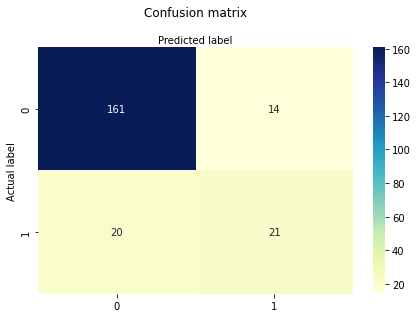

In [33]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [34]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8425925925925926
Precision: 0.6
Recall: 0.5121951219512195
